In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [6]:
# Generate input data (X) and target data (y)
X_data = torch.linspace(-10, 10, 200).reshape(-1, 1)
y_data = (np.sin(5 * np.pi * X_data)) / (5 * np.pi * X_data)


In [7]:
# function to calculate the number of trainable parameters in the model
def count_trainable_params(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params

In [8]:
# neural network model
class ModifiedNN(nn.Module):
    def __init__(self, input_size=1, hidden1=6, hidden2=12, hidden3=6, output_size=1):
        super(ModifiedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1)   # First hidden layer
        self.fc2 = nn.Linear(hidden1, hidden2)      # Second hidden layer
        self.fc3 = nn.Linear(hidden2, hidden3)      # Third hidden layer
        self.fc4 = nn.Linear(hidden3, output_size)  # Output layer

    def forward(self, x):
        x = torch.tanh(self.fc1(x))   # Changed activation to tanh
        x = F.relu(self.fc2(x))       # ReLU activation for second hidden layer
        x = F.relu(self.fc3(x))       # ReLU activation for third hidden layer
        x = self.fc4(x)               # Linear output
        return x

# Initialization
model = ModifiedNN()

# Print the number of trainable parameters
print(f"Total Trainable Parameters: {count_trainable_params(model)}")


Total Trainable Parameters: 181


In [9]:
# Defining layer sizes
layer1_size = 1 * 6
layer2_size = 6 * 12
layer3_size = 12 * 6
layer4_size = 6 * 1
total_model_size = layer1_size + layer2_size + layer3_size + layer4_size

# Use Mean Squared Error loss for regression task
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [10]:
# Hyperparameters
iterations = 8
epochs = 30
collect_interval = epochs // 3  # Collect weights every 3 epochs
total_collections = iterations * collect_interval

# Tensors to hold weights and loss values
layer3_weights = torch.zeros((total_collections, layer3_size))
all_model_weights = torch.zeros((total_collections, total_model_size))
loss_records = torch.zeros((total_collections, 1))

# Placeholder for losses across iterations
loss_list = []

# Training the model multiple times and collecting weights
counter = 0
for run in range(iterations):
    model = ModifiedNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        y_pred = model(X_data)

        # Calculate loss
        loss = criterion(y_pred, y_data)
        loss_list.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Collect weights every 3 epochs
        if epoch % 3 == 0:
            # Collect weights from layers
            w_fc1 = torch.flatten(model.fc1.weight).view(1, layer1_size)
            w_fc2 = torch.flatten(model.fc2.weight).view(1, layer2_size)
            w_fc3 = torch.flatten(model.fc3.weight).view(1, layer3_size)
            w_fc4 = torch.flatten(model.fc4.weight).view(1, layer4_size)

            # Combine the layer weights
            combined_w = torch.cat((w_fc2, w_fc1), dim=1)
            full_weights = torch.cat((combined_w, w_fc3, w_fc4), dim=1)

            # Store weights and corresponding loss
            all_model_weights[counter] = full_weights
            layer3_weights[counter] = w_fc3
            loss_records[counter] = loss
            counter += 1

In [11]:
# Function to perform PCA for dimensionality reduction
def perform_pca(data, reduced_dimensions=2):
    data_centered = data - np.mean(data, axis=0)
    covariance_matrix = np.cov(data_centered.T)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    sorted_indices = np.argsort(eigenvalues)[::-1]
    top_eigenvectors = eigenvectors[:, sorted_indices[:reduced_dimensions]]

    reduced_data = np.dot(data_centered, top_eigenvectors)
    return reduced_data


In [12]:
# Convert tensors to numpy for PCA
layer3_weights_np = layer3_weights.detach().numpy()
model_weights_np = all_model_weights.detach().numpy()
loss_values_np = loss_records.detach().numpy()


In [13]:
# Perform PCA on collected weights (reduce to 2D)
layer3_reduced = perform_pca(layer3_weights_np, 2)
model_weights_reduced = perform_pca(model_weights_np, 2)


<ipython-input-14-dcbbbfb40e40>:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(layer3_reduced[:, 0], layer3_reduced[:, 1], c=colors, s=80, cmap='viridis', edgecolors='k')


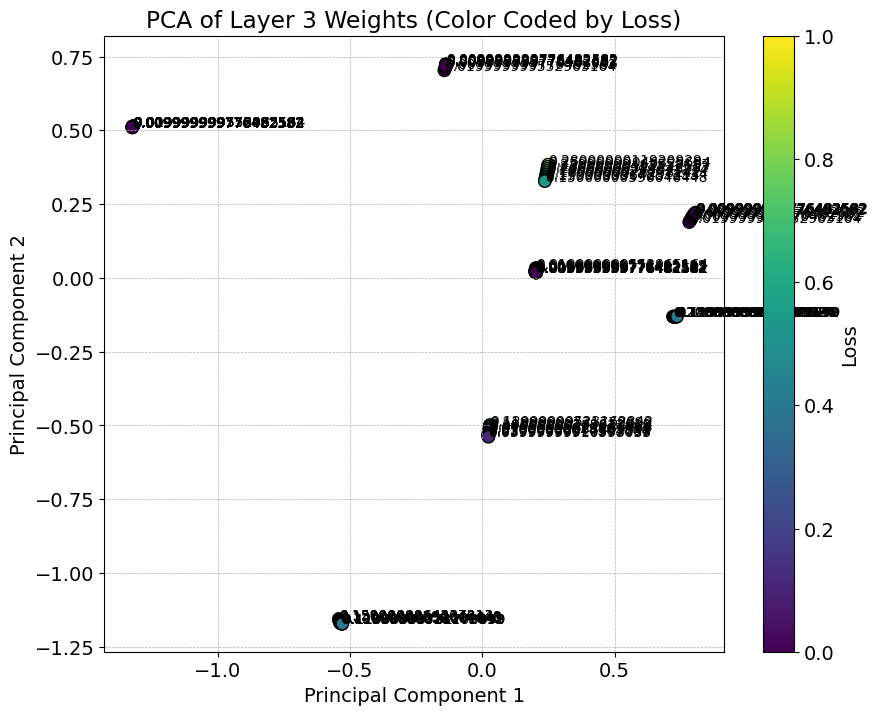

In [14]:
# Define a color map for plotting based on loss values
norm = plt.Normalize(vmin=loss_values_np.min(), vmax=loss_values_np.max())
colors = cm.viridis(norm(loss_values_np.flatten()))

# Increase font size for clearer plots
plt.rcParams.update({'font.size': 14})

# Plot for Layer 3 Weights after PCA
plt.figure(figsize=(10, 8))
plt.scatter(layer3_reduced[:, 0], layer3_reduced[:, 1], c=colors, s=80, cmap='viridis', edgecolors='k')
plt.colorbar(label="Loss")
for i in range(len(layer3_reduced)):
    plt.annotate(f"{round(loss_values_np[i][0], 2)}", (layer3_reduced[i, 0], layer3_reduced[i, 1]), fontsize=10)
plt.title("PCA of Layer 3 Weights (Color Coded by Loss)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

<ipython-input-15-f23b0319b4f6>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(model_weights_reduced[:, 0], model_weights_reduced[:, 1], c=colors, s=80, cmap='plasma', edgecolors='k')


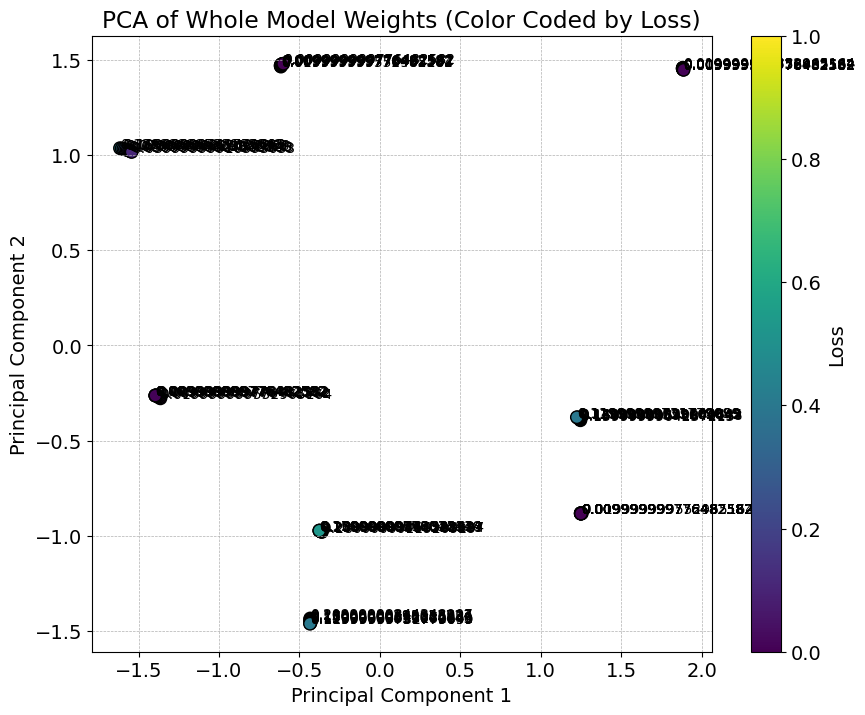

In [15]:
# Plot for Whole Model's Weights after PCA
plt.figure(figsize=(10, 8))
plt.scatter(model_weights_reduced[:, 0], model_weights_reduced[:, 1], c=colors, s=80, cmap='plasma', edgecolors='k')
plt.colorbar(label="Loss")
for i in range(len(model_weights_reduced)):
    plt.annotate(f"{round(loss_values_np[i][0], 2)}", (model_weights_reduced[i, 0], model_weights_reduced[i, 1]), fontsize=10)
plt.title("PCA of Whole Model Weights (Color Coded by Loss)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
